In [32]:
#import library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from datetime import datetime
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [33]:
# Load the bank transaction dataset
# specify the path where your dataset is
df = pd.read_csv('D:/rawdata/tbl_bank_transactions.csv',dtype={'account_number':str,'transaction_amount':float}) 
df.head(5)

,first_name,last_name,email,gender,ip_address,transaction_id,transaction_date_time,account_number,transaction_type,transaction_amount,transaction_currency,merchant_name,merchant_location,transaction_category
0,Tomi,Somefun,Tomi.Somefun-Ogbu@test.com,Female,144.23.8.167,897,2021-04-23 15:07:22,0011168812,transfer,16316.78,IDR,Oyoyo,Room 193,transportation
1,Tomi,Somefun,Tomi.Somefun-Ogbu@test.com,Female,31.188.31.232,898,2021-04-18 16:22:53,0011168812,withdrawal,7362.59,SEK,Yambee,Suite 61,entertainment
2,Tomi,Somefun,Tomi.Somefun-Ogbu@test.com,Female,84.29.217.100,899,2021-12-27 19:52:24,0011168812,withdrawal,29449.95,CNY,Feedbug,Room 939,transportation
3,Tomi,Somefun,Tomi.Somefun-Ogbu@test.com,Female,253.96.14.216,900,2021-07-14 08:19:50,0011168812,deposit,1918.73,JPY,Jabbertype,PO Box 9448,entertainment
4,Tomi,Somefun,Tomi.Somefun-Ogbu@test.com,Female,114.43.19.50,901,2021-04-19 09:47:06,0011168812,withdrawal,23768.32,EUR,Skinder,Suite 4,groceries


In [34]:
# confirm how many records exist and the number of rows and columns
df.shape

(20000, 14)

In [35]:
# we will be working with account_number, transaction_date_time, and transaction_amount
df = df[['account_number','transaction_date_time', 'transaction_amount']]
#peak into the data
df.head(10)

,account_number,transaction_date_time,transaction_amount
0,0011168812,2021-04-23 15:07:22,16316.78
1,0011168812,2021-04-18 16:22:53,7362.59
2,0011168812,2021-12-27 19:52:24,29449.95
3,0011168812,2021-07-14 08:19:50,1918.73
4,0011168812,2021-04-19 09:47:06,23768.32
5,0011168812,2021-04-20 00:31:57,23405.77
6,0011168812,2021-06-07 12:13:21,27543.54
7,0011168812,2021-11-07 01:05:41,29603.04
8,0011168812,2021-10-01 07:34:07,5423.87
9,0011168812,2021-04-12 18:31:24,17143.57


In [36]:
# confirm the data types
df.dtypes

account_number            object
transaction_date_time     object
transaction_amount       float64
dtype: object

In [37]:
#lets convert the transaction_date_time from object to a proper date time
df['transaction_date_time']=pd.to_datetime(df['transaction_date_time'])

In [38]:
df.dtypes

account_number                   object
transaction_date_time    datetime64[ns]
transaction_amount              float64
dtype: object

In [39]:
# We will resample the time-series dataset and aggregate it to hourly intervals
df=df.set_index('transaction_date_time').resample("H").mean().reset_index()
pd.options.display.float_format = '{:.2f}'.format
df

,transaction_date_time,transaction_amount
0,2021-01-01 02:00:00,14392.43
1,2021-01-01 03:00:00,NaN
2,2021-01-01 04:00:00,16013.89
3,2021-01-01 05:00:00,29345.98
4,2021-01-01 06:00:00,19342.44
...,...,...
8729,2021-12-30 19:00:00,26038.15
8730,2021-12-30 20:00:00,9688.55
8731,2021-12-30 21:00:00,23196.56
8732,2021-12-30 22:00:00,11379.05


In [40]:
#check for NAN in the amount 
df.isna().sum()

transaction_date_time      0
transaction_amount       859
dtype: int64

In [41]:
# drop the NaN
df = df.dropna()
df = df.dropna(axis=0)

In [42]:
#check for NAN in the amount 
df.isna().sum()

transaction_date_time    0
transaction_amount       0
dtype: int64

In [43]:
# Let us define a pattern to use for our fraud detection. 
# create a new column called hour and extract hourly value from the transaction_date_time
df['hour']=df.transaction_date_time.dt.hour
# create a new column called weekday and extract the weekday value from transaction_date_time
df['weekday']=pd.Categorical(df.transaction_date_time.dt.strftime('%A'), categories=['Monday','Tuesday','Wednesday',
                                                                                     'Thursday','Friday','Saturday', 
                                                                                     'Sunday'], ordered=True)
df

,transaction_date_time,transaction_amount,hour,weekday
0,2021-01-01 02:00:00,14392.43,2,Friday
2,2021-01-01 04:00:00,16013.89,4,Friday
3,2021-01-01 05:00:00,29345.98,5,Friday
4,2021-01-01 06:00:00,19342.44,6,Friday
5,2021-01-01 07:00:00,8554.83,7,Friday
...,...,...,...,...
8729,2021-12-30 19:00:00,26038.15,19,Thursday
8730,2021-12-30 20:00:00,9688.55,20,Thursday
8731,2021-12-30 21:00:00,23196.56,21,Thursday
8732,2021-12-30 22:00:00,11379.05,22,Thursday


<AxesSubplot:xlabel='weekday'>

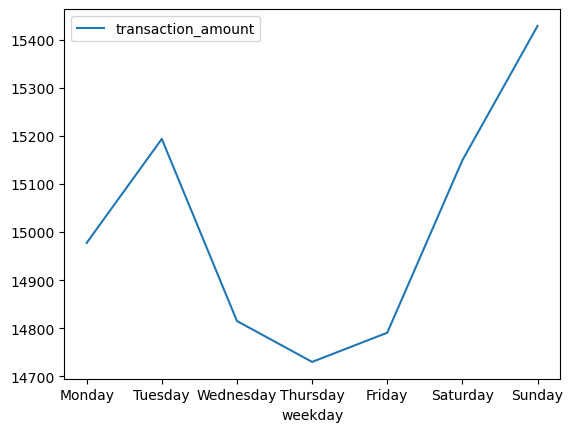

In [44]:
#Plotting line charts
df[['transaction_amount','weekday']].groupby('weekday').mean().plot()

In [45]:
df_Thursday = df.query("weekday == 'Thursday'")
df_Friday = df.query("weekday == 'Friday'")
df_Saturday = df.query("weekday == 'Saturday'")
df_Sunday = df.query("weekday == 'Sunday'")

<AxesSubplot:xlabel='hour'>

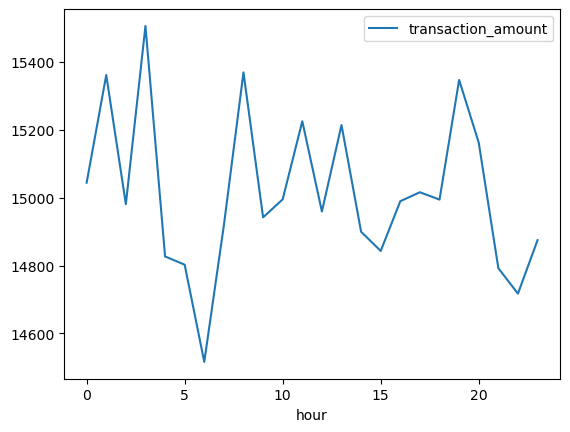

In [46]:
#plot transaction_amount vs hour
df[['transaction_amount','hour']].groupby('hour').mean().plot()

In [47]:
# Lets define a transaction pattern with the transaction amount and hour
# and feed the data to the Isolation Forest model
# Instantiate the model and fit the data into the Isolation Forest Model
# with a contamination value of 0.04 (4%) for the contamination parameter
model=IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(0.04),max_features=1.0, random_state=0)
model.fit(df[['transaction_amount','hour']])

IsolationForest(contamination=0.04, n_estimators=1000, random_state=0)

In [48]:
df['scores']=model.decision_function(df[['transaction_amount','hour']])
df['anomaly']=model.predict(df[['transaction_amount','hour']])
df

,transaction_date_time,transaction_amount,hour,weekday,scores,anomaly
0,2021-01-01 02:00:00,14392.43,2,Friday,0.13,1
2,2021-01-01 04:00:00,16013.89,4,Friday,0.15,1
3,2021-01-01 05:00:00,29345.98,5,Friday,-0.02,-1
4,2021-01-01 06:00:00,19342.44,6,Friday,0.14,1
5,2021-01-01 07:00:00,8554.83,7,Friday,0.12,1
...,...,...,...,...,...,...
8729,2021-12-30 19:00:00,26038.15,19,Thursday,0.05,1
8730,2021-12-30 20:00:00,9688.55,20,Thursday,0.11,1
8731,2021-12-30 21:00:00,23196.56,21,Thursday,0.07,1
8732,2021-12-30 22:00:00,11379.05,22,Thursday,0.10,1


In [49]:
# fetch all the anomalies
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
anomaly

,transaction_date_time,transaction_amount,hour,weekday,scores,anomaly
3,2021-01-01 05:00:00,29345.98,5,Friday,-0.02,-1
46,2021-01-03 00:00:00,25736.57,0,Sunday,-0.01,-1
140,2021-01-06 22:00:00,1919.30,22,Wednesday,-0.02,-1
147,2021-01-07 05:00:00,336.98,5,Thursday,-0.03,-1
160,2021-01-07 18:00:00,1035.40,18,Thursday,-0.01,-1
...,...,...,...,...,...,...
8526,2021-12-22 08:00:00,29568.61,8,Wednesday,-0.02,-1
8529,2021-12-22 11:00:00,834.87,11,Wednesday,-0.01,-1
8568,2021-12-24 02:00:00,29725.07,2,Friday,-0.04,-1
8623,2021-12-26 09:00:00,29455.14,9,Sunday,-0.02,-1


In [50]:
# visualize the outcome for more clarity
fig = px.scatter(df.reset_index(), x='hour', y='transaction_amount', color='anomaly', 
                 hover_data=['transaction_amount'], title='BANK TRANSACTION')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

In [64]:
#lets predict with the model to comfirm same
model.predict([[26000.00,0]])

array([-1])